# Improved LGBM Model for Track Degradation Prediction

This notebook implements an improved version of the LGBM model with:
1. Feature engineering
2. Outlier handling
3. Feature scaling
4. Cross-validation
5. Optimized hyperparameters
6. Feature importance analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# Load data
df = pd.read_csv(r"C:\Users\harsh\OneDrive\Desktop\sana\Internship\cris\track degeneration model\track degradation model  -  data\preprocess_data.csv")

# Display initial information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
display(df.head())

Dataset Shape: (5404343, 8)

Columns: ['SECCODE', 'LINECODE', 'KMFROM', 'BLOCKNO', 'PARAM', 'SD1', 'SD2', 'GMT']

Sample Data:


,SECCODE,LINECODE,KMFROM,BLOCKNO,PARAM,SD1,SD2,GMT
0,1,1,1332,5,AL1L,0.900000,1.100000,14302842
1,1,1,1332,5,AL1L,1.014162,1.205426,12420553
2,1,1,1333,1,AL1L,0.800000,1.200000,5242298
3,1,1,1333,1,AL1L,1.200000,1.300000,14302842
4,1,1,1333,1,AL1L,0.760000,0.860610,8666066


In [6]:
# Drop unnecessary columns
columns_to_drop = ['INSPID', 'FUTURE_DATE']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numerical columns:", len(numerical_cols))
print("Categorical columns:", len(categorical_cols))

Numerical columns: 7
Categorical columns: 1


In [7]:
# Handle outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    return df_clean

# Apply outlier handling
df = remove_outliers(df, numerical_cols)

# Handle missing values
df = df.fillna(df.median(numeric_only=True))

# Display summary statistics after preprocessing
print("Summary statistics after preprocessing:")
display(df.describe())

Summary statistics after preprocessing:


,SECCODE,LINECODE,KMFROM,BLOCKNO,SD1,SD2,GMT
count,5.404343e+06,5.404343e+06,5.404343e+06,5.404343e+06,5.404343e+06,5.404343e+06,5.404343e+06
mean,5.764337e+02,2.020726e+00,4.385933e+02,3.004299e+00,1.935354e+00,2.546474e+00,7.716165e+06
std,4.159924e+02,1.099304e+00,3.944020e+02,1.420772e+00,8.579444e-01,1.196734e+00,4.976878e+06
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,5.597044e-02,3.959408e-01,1.200000e+02
25%,2.220000e+02,1.000000e+00,1.030000e+02,2.000000e+00,1.300000e+00,1.635442e+00,3.885232e+06
50%,5.130000e+02,2.000000e+00,3.130000e+02,3.000000e+00,1.724697e+00,2.259701e+00,6.793260e+06
75%,9.100000e+02,3.000000e+00,7.030000e+02,4.000000e+00,2.400000e+00,3.200000e+00,1.058382e+07
max,1.598000e+03,6.000000e+00,1.590000e+03,7.000000e+00,4.050000e+00,5.546837e+00,2.063171e+07


In [8]:
# Feature Engineering

# 1. Label Encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# 2. Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numerical_cols])
poly_feature_names = poly.get_feature_names_out(numerical_cols)

# Create DataFrame with polynomial features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# 3. Feature Scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Combine original and polynomial features
final_df = pd.concat([df, poly_df], axis=1)

print("Final dataset shape after feature engineering:", final_df.shape)

Final dataset shape after feature engineering: (5404343, 43)


In [9]:
# Feature Engineering
# Add any additional features based on domain knowledge
# For example, you might want to add:
# - Rolling statistics for SD1 and SD2
# - Time-based features from GMT
# - Interaction terms between features

# Convert GMT to datetime and extract features
df['GMT'] = pd.to_datetime(df['GMT'], unit='s')
df['year'] = df['GMT'].dt.year
df['month'] = df['GMT'].dt.month
df['day'] = df['GMT'].dt.day
df['dayofweek'] = df['GMT'].dt.dayofweek

# Add rolling statistics
window_size = 7
df['SD1_rolling_mean'] = df.groupby(['SECCODE', 'LINECODE', 'KMFROM', 'BLOCKNO'])['SD1'].transform(lambda x: x.rolling(window=window_size).mean())
df['SD2_rolling_mean'] = df.groupby(['SECCODE', 'LINECODE', 'KMFROM', 'BLOCKNO'])['SD2'].transform(lambda x: x.rolling(window=window_size).mean())
df['SD1_rolling_std'] = df.groupby(['SECCODE', 'LINECODE', 'KMFROM', 'BLOCKNO'])['SD1'].transform(lambda x: x.rolling(window=window_size).std())
df['SD2_rolling_std'] = df.groupby(['SECCODE', 'LINECODE', 'KMFROM', 'BLOCKNO'])['SD2'].transform(lambda x: x.rolling(window=window_size).std())

# Handle missing values from rolling calculations
df = df.fillna(method='ffill').fillna(method='bfill')

# Prepare features and target
X = df.drop(['SD2', 'GMT'], axis=1)  # Features
y = df['SD2']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Final training set shape: {X_train_scaled.shape}")
print(f"Final test set shape: {X_test_scaled.shape}")

C:\Users\harsh\AppData\Local\Temp\ipykernel_8992\4108697052.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Final training set shape: (4323474, 14)
Final test set shape: (1080869, 14)


In [13]:
# Import required libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, KFold

# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create the base model - Changed to LGBMRegressor
lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=1)

# Set up cross-validation - Changed to KFold (not StratifiedKFold)
cv = KFold(n_splits=3, shuffle=True, random_state=42)



In [14]:
# Perform randomised search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=1,
    random_state=42
)

print("Starting randomized search...")
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("\nBest parameters:", best_params)
print("Best cross-validation score:", random_search.best_score_)



Starting randomized search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score -0.000718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 2882316, number of used features: 14
[LightGBM] [Info] Start training from score 0.000338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 4323474, number of used features: 14
[LightGBM] [Info] Start training from score 0.000045

Best parameters: {'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 300, 'min_child_samples': 50, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best cross-validation score: -0.18918330571362485


In [16]:
# Train the final model with best parameters
print("\nTraining final model with best parameters...")
best_model = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1)  # Changed to LGBMRegressor
best_model.fit(X_train_scaled, y_train)

# Make predictions on training and test sets
print("\nMaking predictions...")
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Calculate metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_accuracy_within_0_5 = np.mean(np.abs(y_train - y_train_pred) <= 0.5) * 100

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_accuracy_within_0_5 = np.mean(np.abs(y_test - y_test_pred) <= 0.5) * 100

# Print all metrics
print("\nTraining Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R2 Score: {train_r2:.4f}")
print(f"Accuracy within ±0.5: {train_accuracy_within_0_5:.2f}%")

print("\nTest Set Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R2 Score: {test_r2:.4f}")
print(f"Accuracy within ±0.5: {test_accuracy_within_0_5:.2f}%")


# Create a DataFrame to store all metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2 Score'],
    'Training': [train_mse, train_mae, train_r2],
    'Test': [test_mse, test_mae, test_r2]
})




Training final model with best parameters...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 4323474, number of used features: 14
[LightGBM] [Info] Start training from score 0.000045

Making predictions...


c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Training Set Metrics:
Mean Squared Error (MSE): 0.1882
Mean Absolute Error (MAE): 0.2925
R2 Score: 0.8118
Accuracy within ±0.5: 84.78%

Test Set Metrics:
Mean Squared Error (MSE): 0.1900
Mean Absolute Error (MAE): 0.2936
R2 Score: 0.8099
Accuracy within ±0.5: 84.69%



All Metrics Summary:


,Metric,Training,Test
0,MSE,0.188179,0.190038
1,MAE,0.292476,0.293559
2,R2 Score,0.811824,0.809950


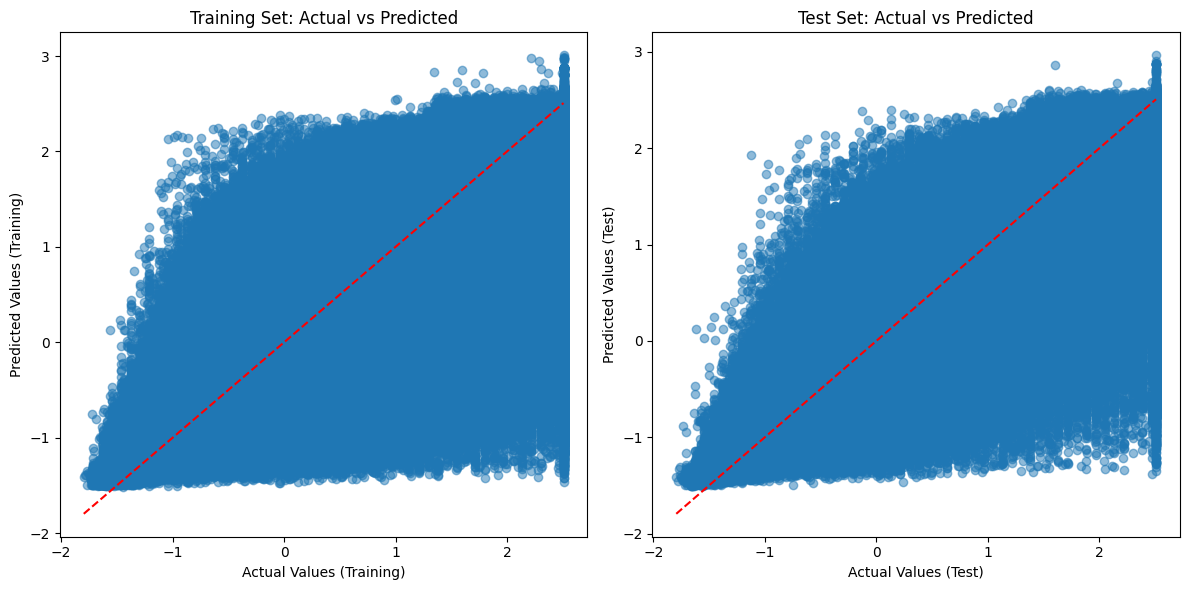

In [17]:
# Display the metrics in a table
print("\nAll Metrics Summary:")
display(metrics_df)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Values (Training)')
plt.ylabel('Predicted Values (Training)')
plt.title('Training Set: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values (Test)')
plt.ylabel('Predicted Values (Test)')
plt.title('Test Set: Actual vs Predicted')

plt.tight_layout()
plt.show()

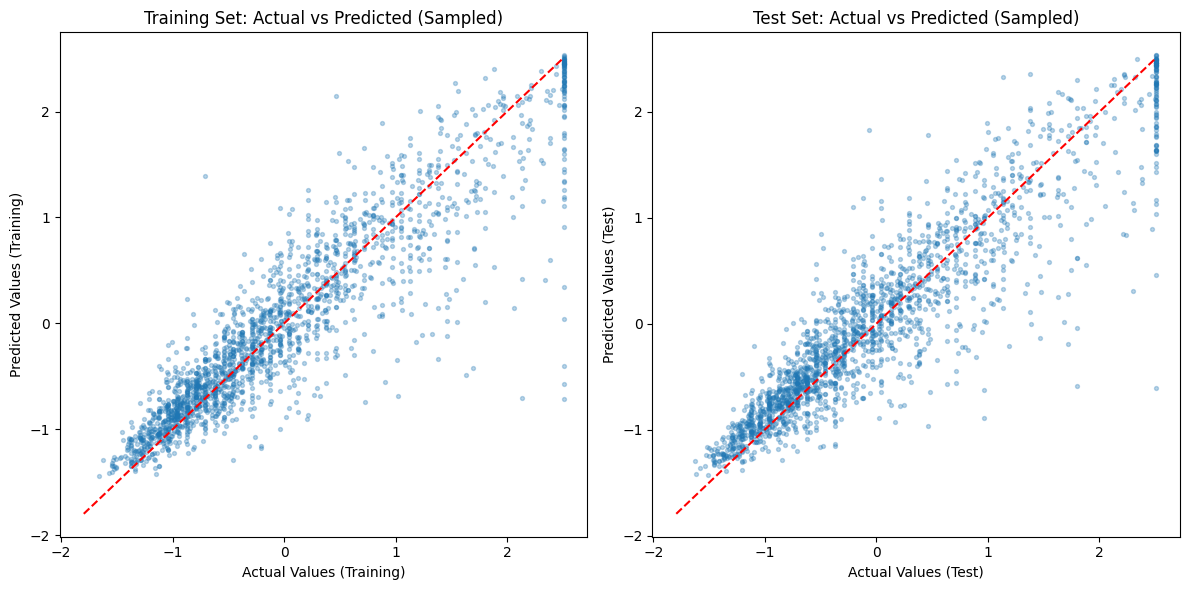

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train.iloc[train_sample], np.array(y_train_pred)[train_sample], alpha=0.3, s=8)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Values (Training)')
plt.ylabel('Predicted Values (Training)')
plt.title('Training Set: Actual vs Predicted (Sampled)')

plt.subplot(1, 2, 2)
plt.scatter(y_test.iloc[test_sample], np.array(y_test_pred)[test_sample], alpha=0.3, s=8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values (Test)')
plt.ylabel('Predicted Values (Test)')
plt.title('Test Set: Actual vs Predicted (Sampled)')

plt.tight_layout()
plt.show()

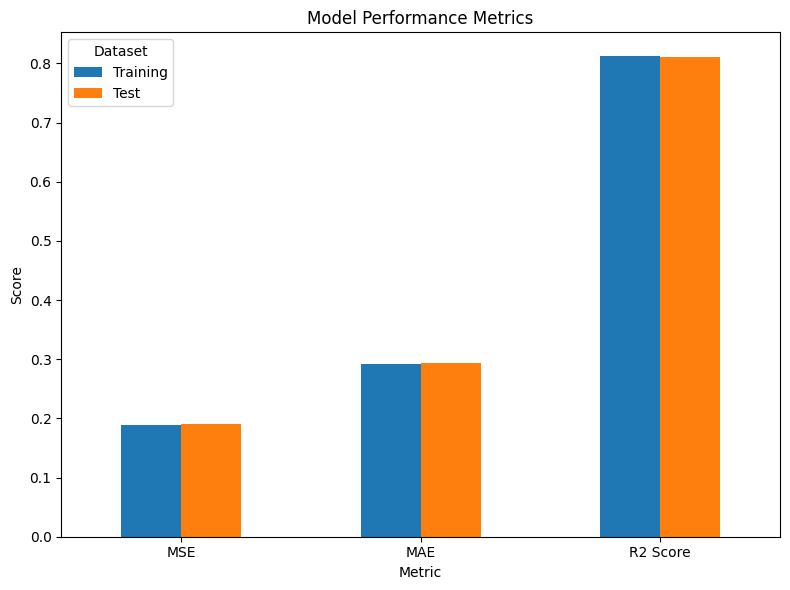

In [23]:
import matplotlib.pyplot as plt

# Assuming metrics_df is already created as in your notebook:
# metrics_df = pd.DataFrame({
#     'Metric': ['MSE', 'MAE', 'R2 Score'],
#     'Training': [train_mse, train_mae, train_r2],
#     'Test': [test_mse, test_mae, test_r2]
# })

# Set the metric as index for easier plotting
metrics_df_plot = metrics_df.set_index('Metric')

# Plotting
metrics_df_plot.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

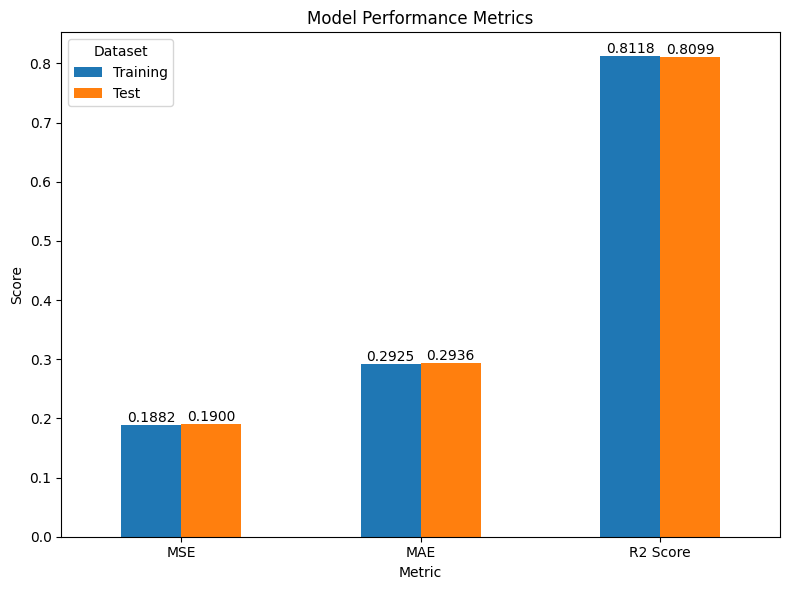

In [24]:
import matplotlib.pyplot as plt

# Set the metric as index for easier plotting
metrics_df_plot = metrics_df.set_index('Metric')

ax = metrics_df_plot.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.tight_layout()

# Annotate bars with values
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f'{value:.4f}', 
                (p.get_x() + p.get_width() / 2, value), 
                ha='center', va='bottom', fontsize=10, rotation=0)

plt.show()

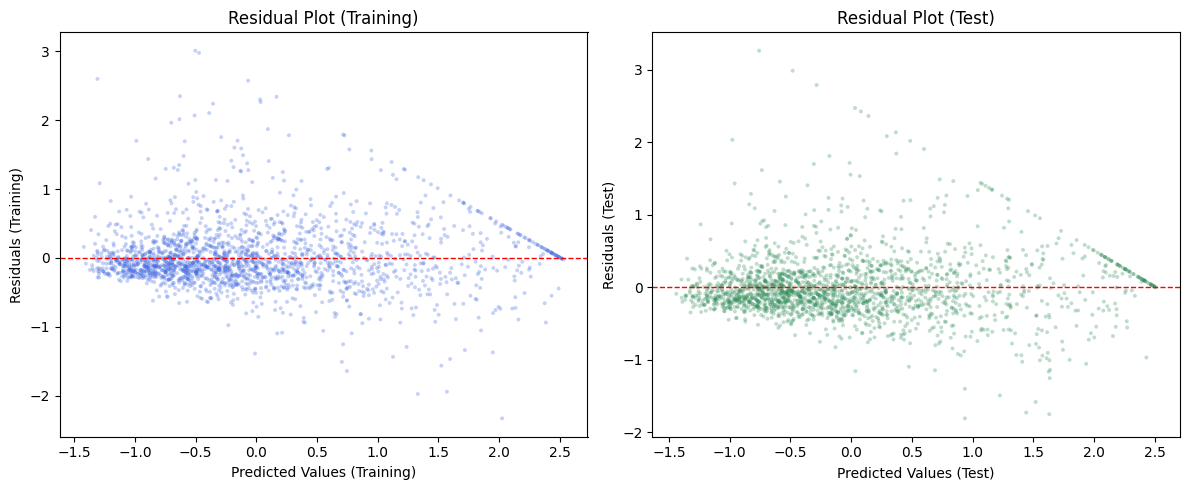

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Sample up to 10,000 points for clarity
train_sample = np.random.choice(len(y_train), size=min(2000, len(y_train)), replace=False)
test_sample = np.random.choice(len(y_test), size=min(2000, len(y_test)), replace=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.array(y_train_pred)[train_sample], np.array(train_residuals)[train_sample], 
            alpha=0.3, s=8, color='royalblue', edgecolor='none')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values (Training)')
plt.ylabel('Residuals (Training)')
plt.title('Residual Plot (Training)')

plt.subplot(1, 2, 2)
plt.scatter(np.array(y_test_pred)[test_sample], np.array(test_residuals)[test_sample], 
            alpha=0.3, s=8, color='seagreen', edgecolor='none')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values (Test)')
plt.ylabel('Residuals (Test)')
plt.title('Residual Plot (Test)')

plt.tight_layout()
plt.show()

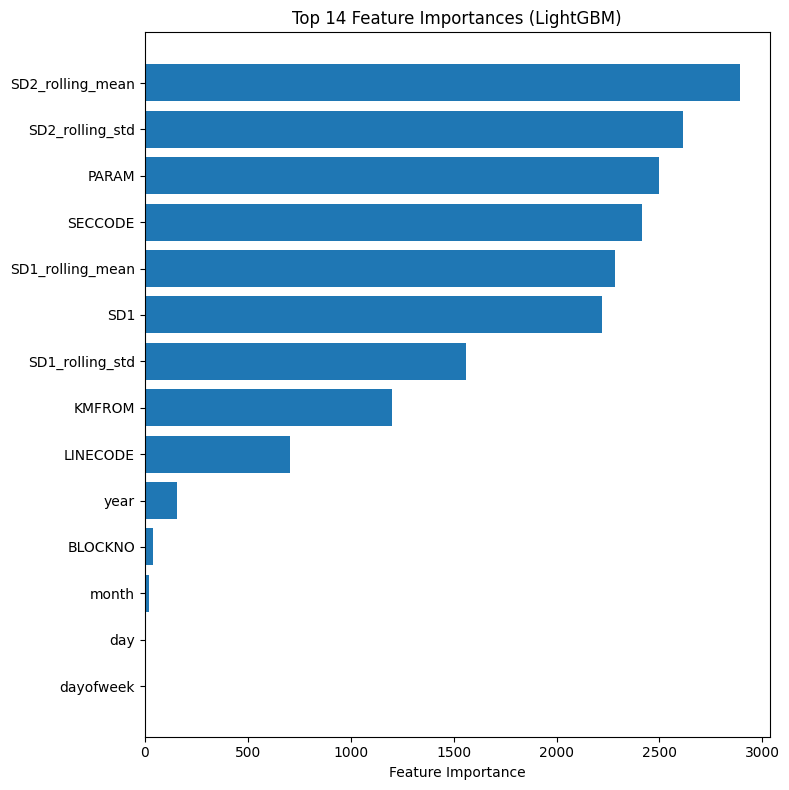

In [29]:
importances = best_model.feature_importances_
feature_names = X_train.columns  # or X.columns if you used all features

top_n = min(20, len(importances))  # Adjust top_n if you have fewer features

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 8))
plt.barh(range(top_n), importances[indices][:top_n], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (LightGBM)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()